# Subset seeding locations of the Global Model inside the Caribbean regions

Distribution based on:
- Lebreton and Andrady 2019
- Lebreton and Reisser (River inputs)

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from matplotlib import path, colors
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Polygon, Rectangle
import urllib.request
import skimage.io as io
import os
from os.path import join
import sys
from datetime import datetime
import scipy as sc
from scipy import stats
from scipy.ndimage import generic_filter
import xarray as xr
from scipy.interpolate import RegularGridInterpolator
import shapely
import cartopy.io.shapereader as shpreader
import cmocean
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap_name = plt.cm.turbo

In [2]:
from caribbean_map import *

In [3]:
# parameters
light_particle_ratio = 0.6  # Lebreton, meaning that 40% sink on release

## Data from Lebreton and Andrady 2019 ([link](https://doi.org/10.6084/m9.figshare.5900335.v3))

In [4]:
# download the raw data
file = "../data/raw/LebretonAndrady2019_MismanagedPlasticWaste.tif"
if not os.path.isfile(file):
    url = "https://figshare.com/ndownloader/files/28891242"
    req = urllib.request.urlretrieve(url, file)
else:
    pass

In [5]:
# mismanaged plastic waste generation in kg/year
mpw = io.imread(
    "../data/raw/LebretonAndrady2019_MismanagedPlasticWaste.tif"
)  # [kg/year]
mpw_to_ocean_ratio = 0.25  # Jambeck and Lebreton
mpw = np.flipud(mpw) / 1000 * mpw_to_ocean_ratio  # [tons/year]
mpw[mpw == 0] = np.nan

In [6]:
lon_range = [-99, -51]
lat_range = [0, 31.5]

In [7]:
lon = np.linspace(-180, 180, mpw.shape[1])
lat = np.linspace(-90, 90, mpw.shape[0])

# subset
i0 = np.argmin(np.abs(lon - lon_range[0]))
i1 = np.argmin(np.abs(lon - lon_range[1]))
j0 = np.argmin(np.abs(lat - lat_range[0]))
j1 = np.argmin(np.abs(lat - lat_range[1]))

lon = lon[slice(i0, i1)]
lat = lat[slice(j0, j1)]
mpw = mpw[slice(j0, j1), slice(i0, i1)]

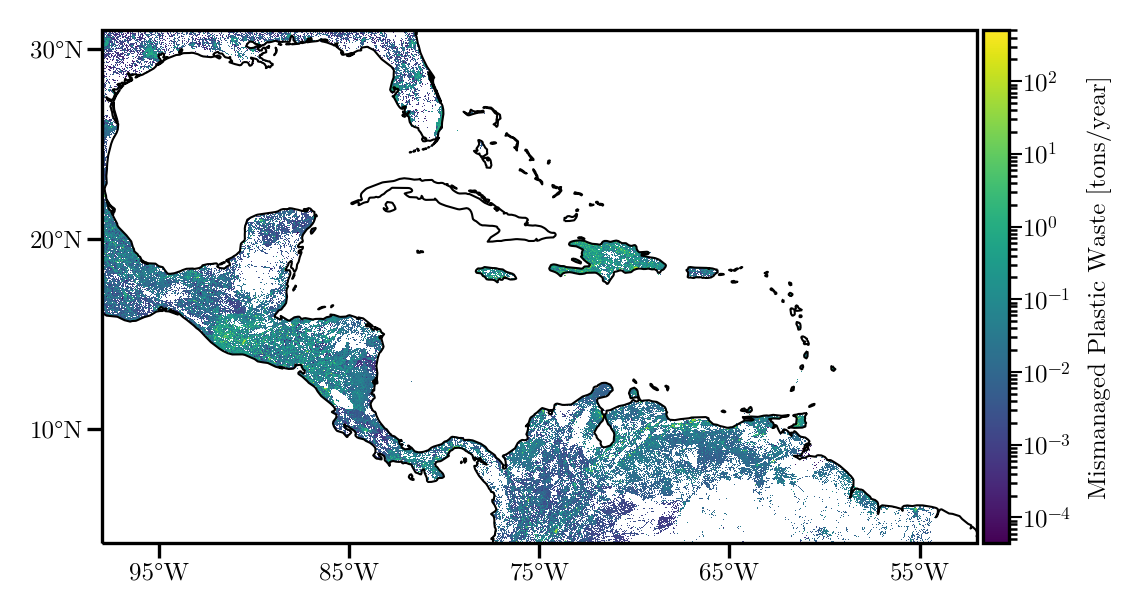

In [8]:
fig = plt.figure(dpi=300, figsize=fsh)
ax = fig.add_subplot(1, 1, 1, aspect="equal", projection=ccrs.PlateCarree())

skip = 1
pcm1 = ax.pcolormesh(
    lon[::skip], lat[::skip], mpw[::skip, ::skip], shading="auto", norm=colors.LogNorm()
)

geo_map(ax, land=False)
cb = add_colorbar(fig, ax, pcm1)
cb.set_label("Mismanaged Plastic Waste [tons/year]", fontsize=6)

## Keep everything within 50 km from the coast

In [9]:
# distance to coast
# Global griddata of closest distance to shore
df = xr.open_dataset("../data/raw/dist_to_GSHHG_v2.3.7_1m.nc")
dist2coast = RegularGridInterpolator(
    (df.lon.data, df.lat.data), df.dist.data.T
)  # have to pass .data (!)
df.close()

In [10]:
mlon, mlat = np.meshgrid(lon, lat)

# dist2coast positive on land and negative in the ocean
keep = (
    dist2coast(np.column_stack((mlon.flatten() % 360, mlat.flatten()))) < 50
).reshape(mlon.shape)

mpw_coast = np.zeros_like(mpw)
mpw_coast[keep] = mpw[keep]

## Smallest resolution we can keep is the size of the model, so we bin everything to the model grid.

In [11]:
ds = xr.open_dataset("../data/process/land_GLBv0.08.nc")
land = ds.land.values
land2x = generic_filter(land, lambda x: np.max(x), size=3, mode="constant")
plon = ds.plon.values  # center of cell
plat = ds.plat.values
qlon = ds.qlon.values  # corner of cell
qlat = ds.qlat.values
ds.close()

In [12]:
ret_c = stats.binned_statistic_2d(
    mlon.flatten(),
    mlat.flatten(),
    mpw_coast.flatten(),
    statistic=np.nansum,
    bins=[qlon, qlat],
)
model_mpw = ret_c.statistic.T

## Move the plastic to the closest ocean bins (2 grid cells away from the coast)

In [13]:
gplon, gplat = np.meshgrid(plon, plat)
gi, gj = np.where(land2x == 0)
ocean_lon, ocean_lat = gplon[land2x == 0], gplat[land2x == 0]

In [14]:
@nb.njit
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.
    """
    lon1, lat1 = np.radians(lon1), np.radians(lat1)
    lon2, lat2 = np.radians(lon2), np.radians(lat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2

    # distance
    earthRadius = 6371  # km
    d = 2 * np.arcsin(np.sqrt(a)) * earthRadius  # km
    return d

In [15]:
model_ocean_mpw = np.zeros_like(model_mpw)

for i, j in zip(*np.where(model_mpw > 0)):
    d = haversine(plon[j], plat[i], ocean_lon, ocean_lat)  # i,j inverted
    k = np.argmin(d)  # closest ocean box
    model_ocean_mpw[gi[k], gj[k]] += model_mpw[i, j]  # (i,j) -> (gi[k], gj[k])

## Only keep values in the Caribbean region

In [16]:
xc = np.array(
    [-51.6, -76.8, -78, -79.3, -81, -82.7, -87.3, -98.5, -98.5, -66.7, -51.6, -51.6]
)
yc = np.array([3.5, 7, 8.6, 9.2, 8.2, 8.8, 14.8, 19.0, 31.0, 31.0, 31.0, 3.9])
p = path.Path(np.vstack((xc, yc)).T)
remove = np.where(
    ~p.contains_points(np.column_stack((gplon.flatten(), gplat.flatten())))
)
model_mpw[np.unravel_index(remove, model_mpw.shape)] = 0
model_ocean_mpw[np.unravel_index(remove, model_ocean_mpw.shape)] = 0

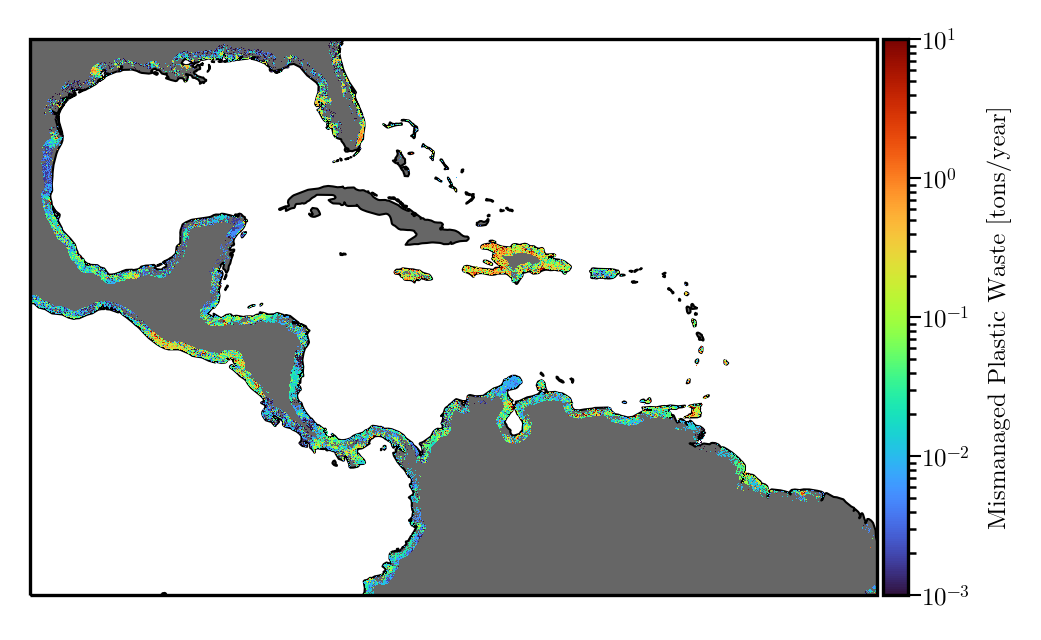

In [69]:
# coastal mpw
fig = plt.figure(dpi=300, figsize=fsh)
ax = fig.add_subplot(1, 1, 1, aspect="equal", projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
ax.add_feature(cfeature.LAND, facecolor='0.4', zorder=-1)

pcm1 = ax.pcolormesh(
    lon,
    lat,
    mpw_coast,
    shading="auto",
    norm=colors.LogNorm(vmin=1e-3, vmax=10),
    cmap="turbo",
)

cb = add_colorbar(fig, ax, pcm1)
cb.set_label("Mismanaged Plastic Waste [tons/year]", fontsize=6)
fig.savefig("figures/distribution_land.png", bbox_inches="tight", format="png", dpi=600)

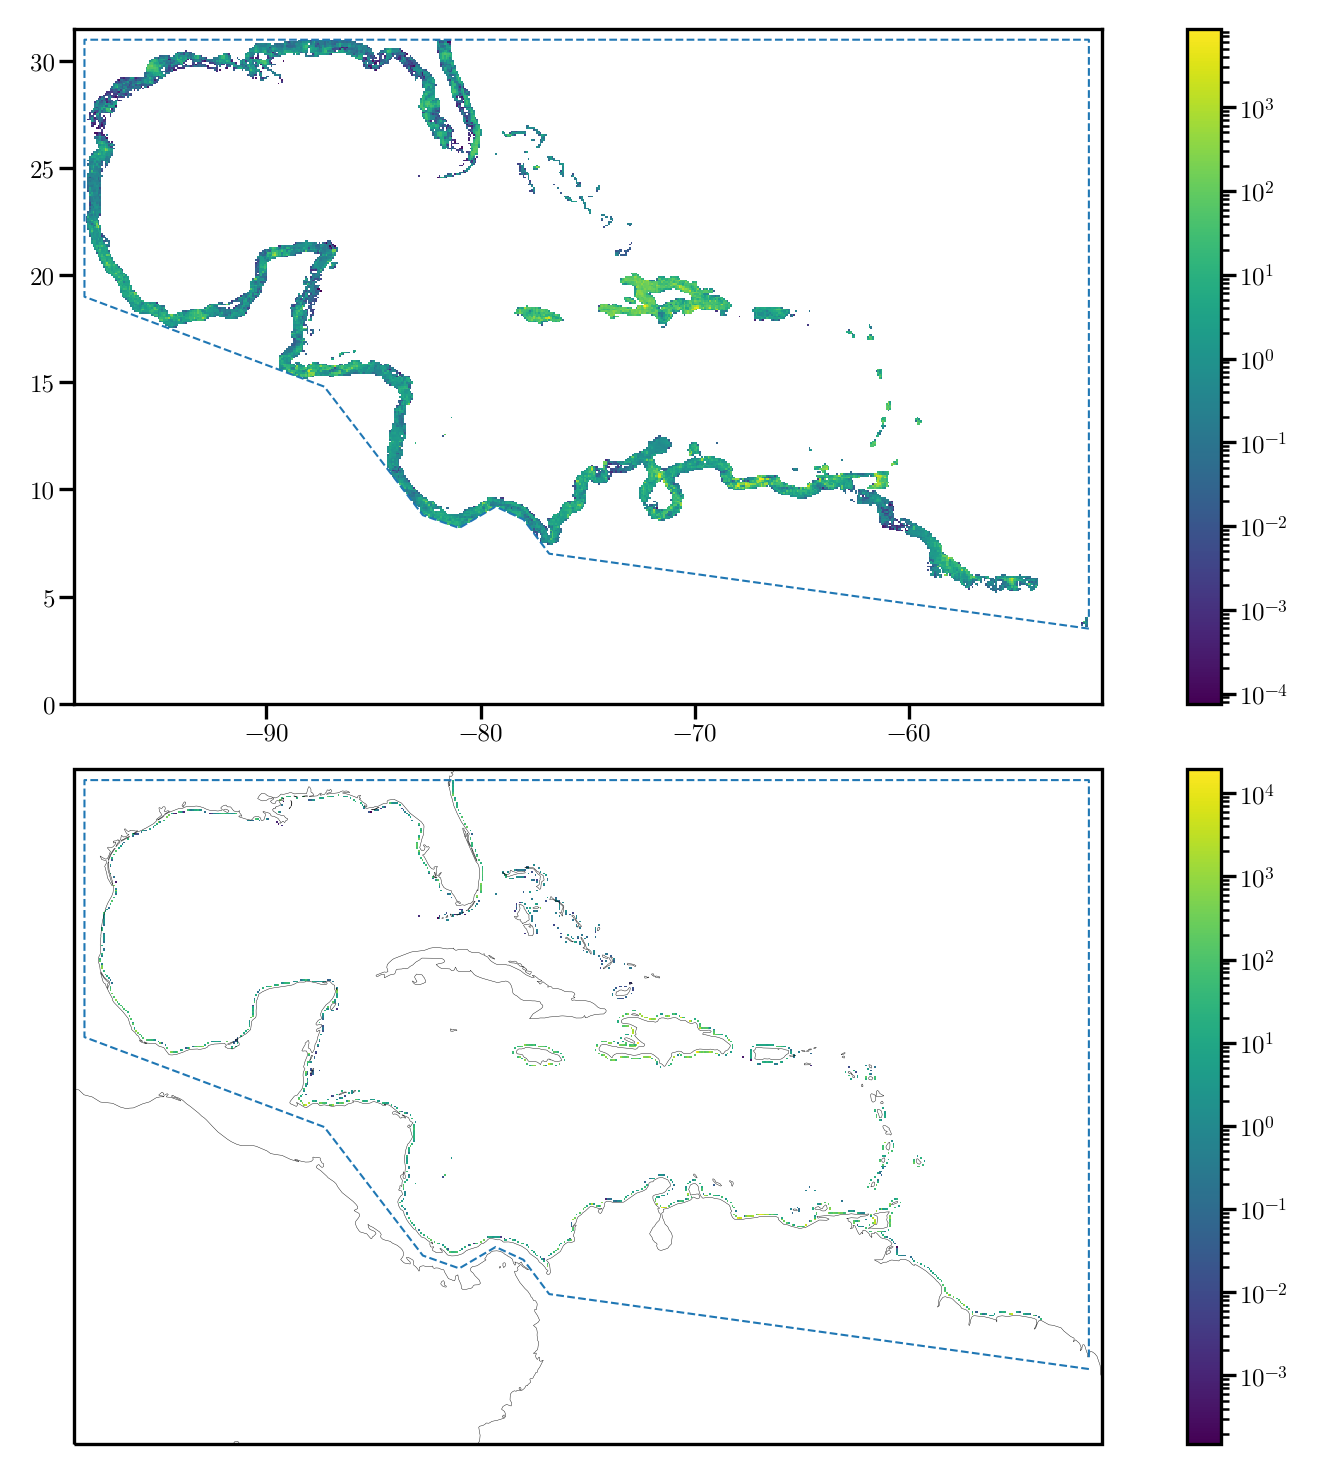

In [37]:
# model mpw and model mpw moved to the ocean
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(2, 1, 1, aspect="equal")
ax2 = fig.add_subplot(2, 1, 2, aspect="equal", projection=ccrs.PlateCarree())

skip = 1
pcm1 = ax1.pcolormesh(qlon, qlat, model_mpw, shading="auto", norm=colors.LogNorm())

pcm2 = ax2.pcolormesh(
    qlon,
    qlat,
    model_ocean_mpw,
    shading="auto",
    norm=colors.LogNorm(),
    transform=ccrs.PlateCarree(),
)

ax1.plot(xc, yc, linewidth=0.5, linestyle="--")

ax2.plot(xc, yc, linewidth=0.5, linestyle="--", transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, linewidth=0.1, zorder=1)

ax1.set_xlim(lon_range)
ax1.set_ylim(lat_range)
ax2.set_xlim(lon_range)
ax2.set_ylim(lat_range)

fig.colorbar(pcm1, ax=ax1)
fig.colorbar(pcm2, ax=ax2)

# Generate particles randomly into model box containing trash

In [19]:
def number_of_particles(tons):
    """
    Convert tons of plastic per year to a number of particles
    according to a predefined ranges and base number.

    """
    ranges = np.array([0, 1, 10, 100, 1000, 10000, 100000])
    base_nb_particle = 4
    exp = ranges.searchsorted(tons, "right") - 2  # discard < 1 ton / year

    if exp >= 0:
        return base_nb_particle**exp
    else:
        return 0

In [20]:
# load country information
ds = xr.open_dataset("../data/process/country_GLBv0.08.nc")
closest_cid = ds.country.values
lon_cid = ds.plon.values
lat_cid = ds.plat.values
f_cid = RegularGridInterpolator((lon_cid, lat_cid), closest_cid.T, method="nearest")
ds.close()

In [21]:
np.random.seed(42)

coast_x = []
coast_y = []
coast_w = []
coast_cid = []
pj, pi = np.where(model_ocean_mpw > 0)  # index of non zero grid cell
for i in range(0, len(pi)):
    mass = model_ocean_mpw[pj[i], pi[i]]
    n = number_of_particles(mass)

    dx = qlon[pi[i] + 1] - qlon[pi[i]]
    dy = qlat[pj[i] + 1] - qlat[pj[i]]

    coast_x.append(qlon[pi[i]] + np.random.random_sample(n) * dx)
    coast_y.append(qlat[pj[i]] + np.random.random_sample(n) * dy)
    particles_mass = (
        mass / 12 * light_particle_ratio
    )  # weight of monthly light particles [tons]
    coast_w.append(np.full(n, particles_mass / n) if n else np.empty(0))
    coast_cid.append(
        np.full(n, f_cid([qlon[pi[i]], qlat[pj[i]]]), dtype="int")
        if n
        else np.empty(0, dtype="int")
    )

In [22]:
len(np.unique(np.hstack(coast_cid)))

25

In [23]:
print(f"A total of {sum([len(a) for a in coast_x])} land particles.")

A total of 10526 land particles.


## Stats about the land particles

In [24]:
print(f"There are {len(np.where(model_ocean_mpw.flatten())[0])} nonzero bins.")

There are 1460 nonzero bins.


In [25]:
ranges = [0, 1, 10, 100, 1000, 10000, 100000]
mass = []
count = []
for i in range(0, len(ranges) - 1):
    r = np.logical_and(
        model_ocean_mpw.flatten() > ranges[i], model_ocean_mpw.flatten() < ranges[i + 1]
    )
    mass.append(np.sum(model_ocean_mpw.flatten()[r]))
    count.append(np.sum(r))

In [26]:
count

[381, 298, 465, 259, 54, 3]

In [27]:
mass

[92.29679699375001,
 1224.2468094647502,
 17821.454953210497,
 83799.09196173301,
 156318.78062423048,
 53120.244787715004]

In [28]:
mass / np.sum(mass) * 100

array([2.95466882e-02, 3.91914345e-01, 5.70512726e+00, 2.68263442e+01,
       5.00418478e+01, 1.70052197e+01])

In [29]:
nb_part = 0
n = 4
for i in range(1, len(count)):
    print(n ** (i - 1) * count[i], end=" ")
    nb_part += n ** (i - 1) * count[i]

print(f"\nTotal number of particles {np.sum(nb_part)}.")

298 1860 4144 3456 768 
Total number of particles 10526.


## validation of the particles generation

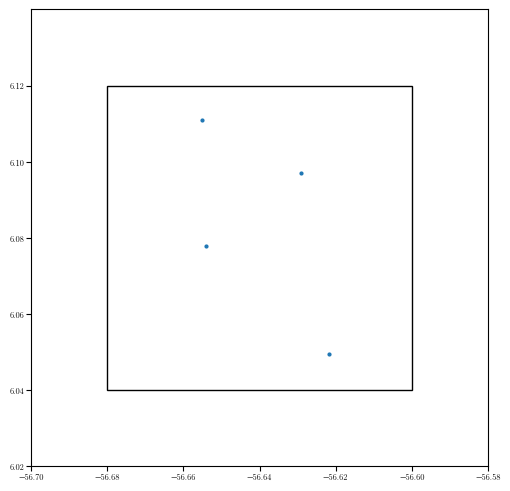

In [30]:
i = 8

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax.add_patch(
    Rectangle((qlon[pi[i]], qlat[pj[i]]), dx, dy, facecolor="None", edgecolor="black")
)

ax.scatter(coast_x[i], coast_y[i], s=4)

ax.set_xlim(qlon[pi[i]] - dx / 4, qlon[pi[i] + 1] + dx / 4)
ax.set_ylim(qlat[pj[i]] - dy / 4, qlat[pj[i] + 1] + dy / 4);

# River plastic emissions to the world's oceans ([link](https://figshare.com/articles/dataset/River_plastic_emissions_to_the_world_s_oceans/4725541/4))
- mismanaged plastic waste from 40,760 river input locations in kg per year. 

In [31]:
# download the raw data
file = "../data/raw/PlasticRiverInputs/PlasticRiverInputs.shp"
if not os.path.isfile(file):
    url = "https://figshare.com/ndownloader/files/7714864"
    req = urllib.request.urlretrieve(url, file)
else:
    pass

mpw_r = shpreader.Reader(file)

nb_records = 40760
rivers_xy = np.zeros((nb_records, 2))
rivers_mpw = np.zeros(nb_records)

for i, r in enumerate(mpw_r.records()):
    rivers_xy[i, :] = r.geometry.coords
    rivers_mpw[i] = r.attributes["i_mid"] if r.attributes["i_mid"] else 0  # [tons/year]

In [32]:
len(rivers_xy)

40760

## binned river pollution into the GLBv0.08 model grid

In [33]:
ret_r = stats.binned_statistic_2d(
    rivers_xy[:, 0], rivers_xy[:, 1], rivers_mpw, statistic=np.nansum, bins=[qlon, qlat]
)
model_mpw_r = ret_r.statistic.T

## move to closest ocean grid

In [34]:
model_ocean_mpw_r = np.zeros_like(model_mpw_r)

for i, j in zip(*np.where(model_mpw_r > 0)):
    d = haversine(plon[j], plat[i], ocean_lon, ocean_lat)  # i,j inverted
    k = np.argmin(d)  # closest ocean box
    model_ocean_mpw_r[gi[k], gj[k]] += model_mpw_r[i, j]  # (i,j) -> (gi[k], gj[k])

## Only keep values in the Caribbean region

In [35]:
remove = np.where(
    ~p.contains_points(np.column_stack((gplon.flatten(), gplat.flatten())))
)
model_mpw_r[np.unravel_index(remove, model_mpw_r.shape)] = 0
model_ocean_mpw_r[np.unravel_index(remove, model_ocean_mpw_r.shape)] = 0

In [64]:
def radius(mass):
    categories = np.array([10, 100, 1000, 10000])
    size = np.array([1, 2.0, 4, 6.0]) / 5
    arg = np.array([np.argmin(np.abs(m - categories)) for m in mass])
    return arg + 0.5, size[arg]

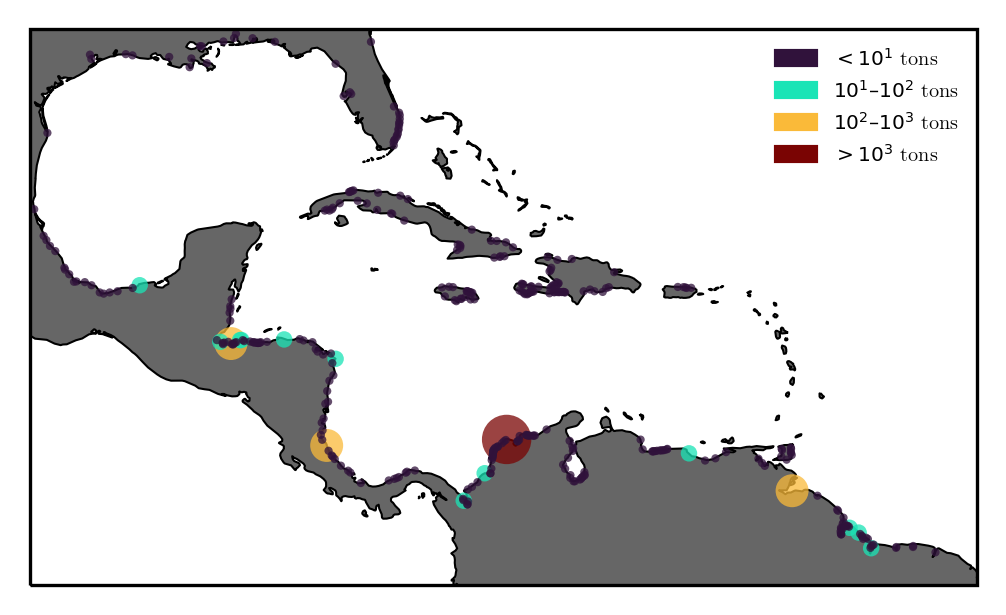

In [68]:
# coastal mpw from rivers
fig = plt.figure(dpi=300, figsize=fsh)
ax = fig.add_subplot(1, 1, 1, aspect="equal", projection=ccrs.PlateCarree())

s_idx = np.argsort(rivers_mpw)[::-1]
s_rivers_xy = rivers_xy[s_idx]
s_rivers_mpw = rivers_mpw[s_idx]

# keep only river boxes in the Caribbean with MPW values larger than 0
keep = np.intersect1d(
    np.where(
        p.contains_points(np.column_stack((s_rivers_xy[:, 0], s_rivers_xy[:, 1])))
    ),
    np.where(s_rivers_mpw > 0.1),
)

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
ax.add_feature(cfeature.LAND, facecolor='0.4', zorder=-1)
ax.set_extent([-98, -52, 4, 31], crs=plot_crs)

# pcm = ax.scatter(s_rivers_xy[:,0][keep],
#                 s_rivers_xy[:,1][keep],
#                 s=15*np.log(s_rivers_mpw[keep]),
#                 c=s_rivers_mpw[keep],
#                 cmap='viridis',
#                 norm=colors.LogNorm(),
#                 alpha=0.75)

# get size of the circles and their colors from the function
colors_mass, scaled_mass = radius(s_rivers_mpw[keep])

patches = []
for x1, y1, r in sorted(
    zip(s_rivers_xy[:, 0][keep], s_rivers_xy[:, 1][keep], scaled_mass),
    key=lambda x: x[2],
    reverse=True,
):
    circle = Circle((x1, y1), r)
    patches.append(circle)

pp = PatchCollection(patches, alpha=0.75, cmap=cmap_name)
pp.set_array(colors_mass)
pp.set_clim([np.min(colors_mass), np.max(colors_mass)])
ax.add_collection(pp)

handles = []
handles.append(
    Polygon(
        [(0, 0), (5, 0)],
        color=cmap_name(pp.norm(np.min(colors_mass))),
        label=f"$<10^{1}$ tons",
    )
)
for i, c in enumerate(np.unique(colors_mass)[1:-1]):
    handles.append(
        Polygon(
            [(0, 0), (10, 0), (0, -10)],
            color=cmap_name(pp.norm(c)),
            label=f"$10^{i+1}–10^{i+2}$ tons",
        )
    )
handles.append(
    Polygon(
        [(0, 0), (10, 0), (0, -10)],
        color=cmap_name(pp.norm(np.max(colors_mass))),
        label=f"$>10^{i+2}$ tons",
    )
)
ax.legend(handles=handles, frameon=False, fontsize="x-small")

fig.savefig(
    "figures/distribution_rivers.png", bbox_inches="tight", format="png", dpi=600
)

In [41]:
len(s_rivers_mpw[keep])

356

In [42]:
np.sum(s_rivers_mpw[keep] > 0.1)

356

In [43]:
np.min(s_rivers_mpw[keep])

0.1003

In [44]:
np.max(s_rivers_mpw[keep])

16707.921786

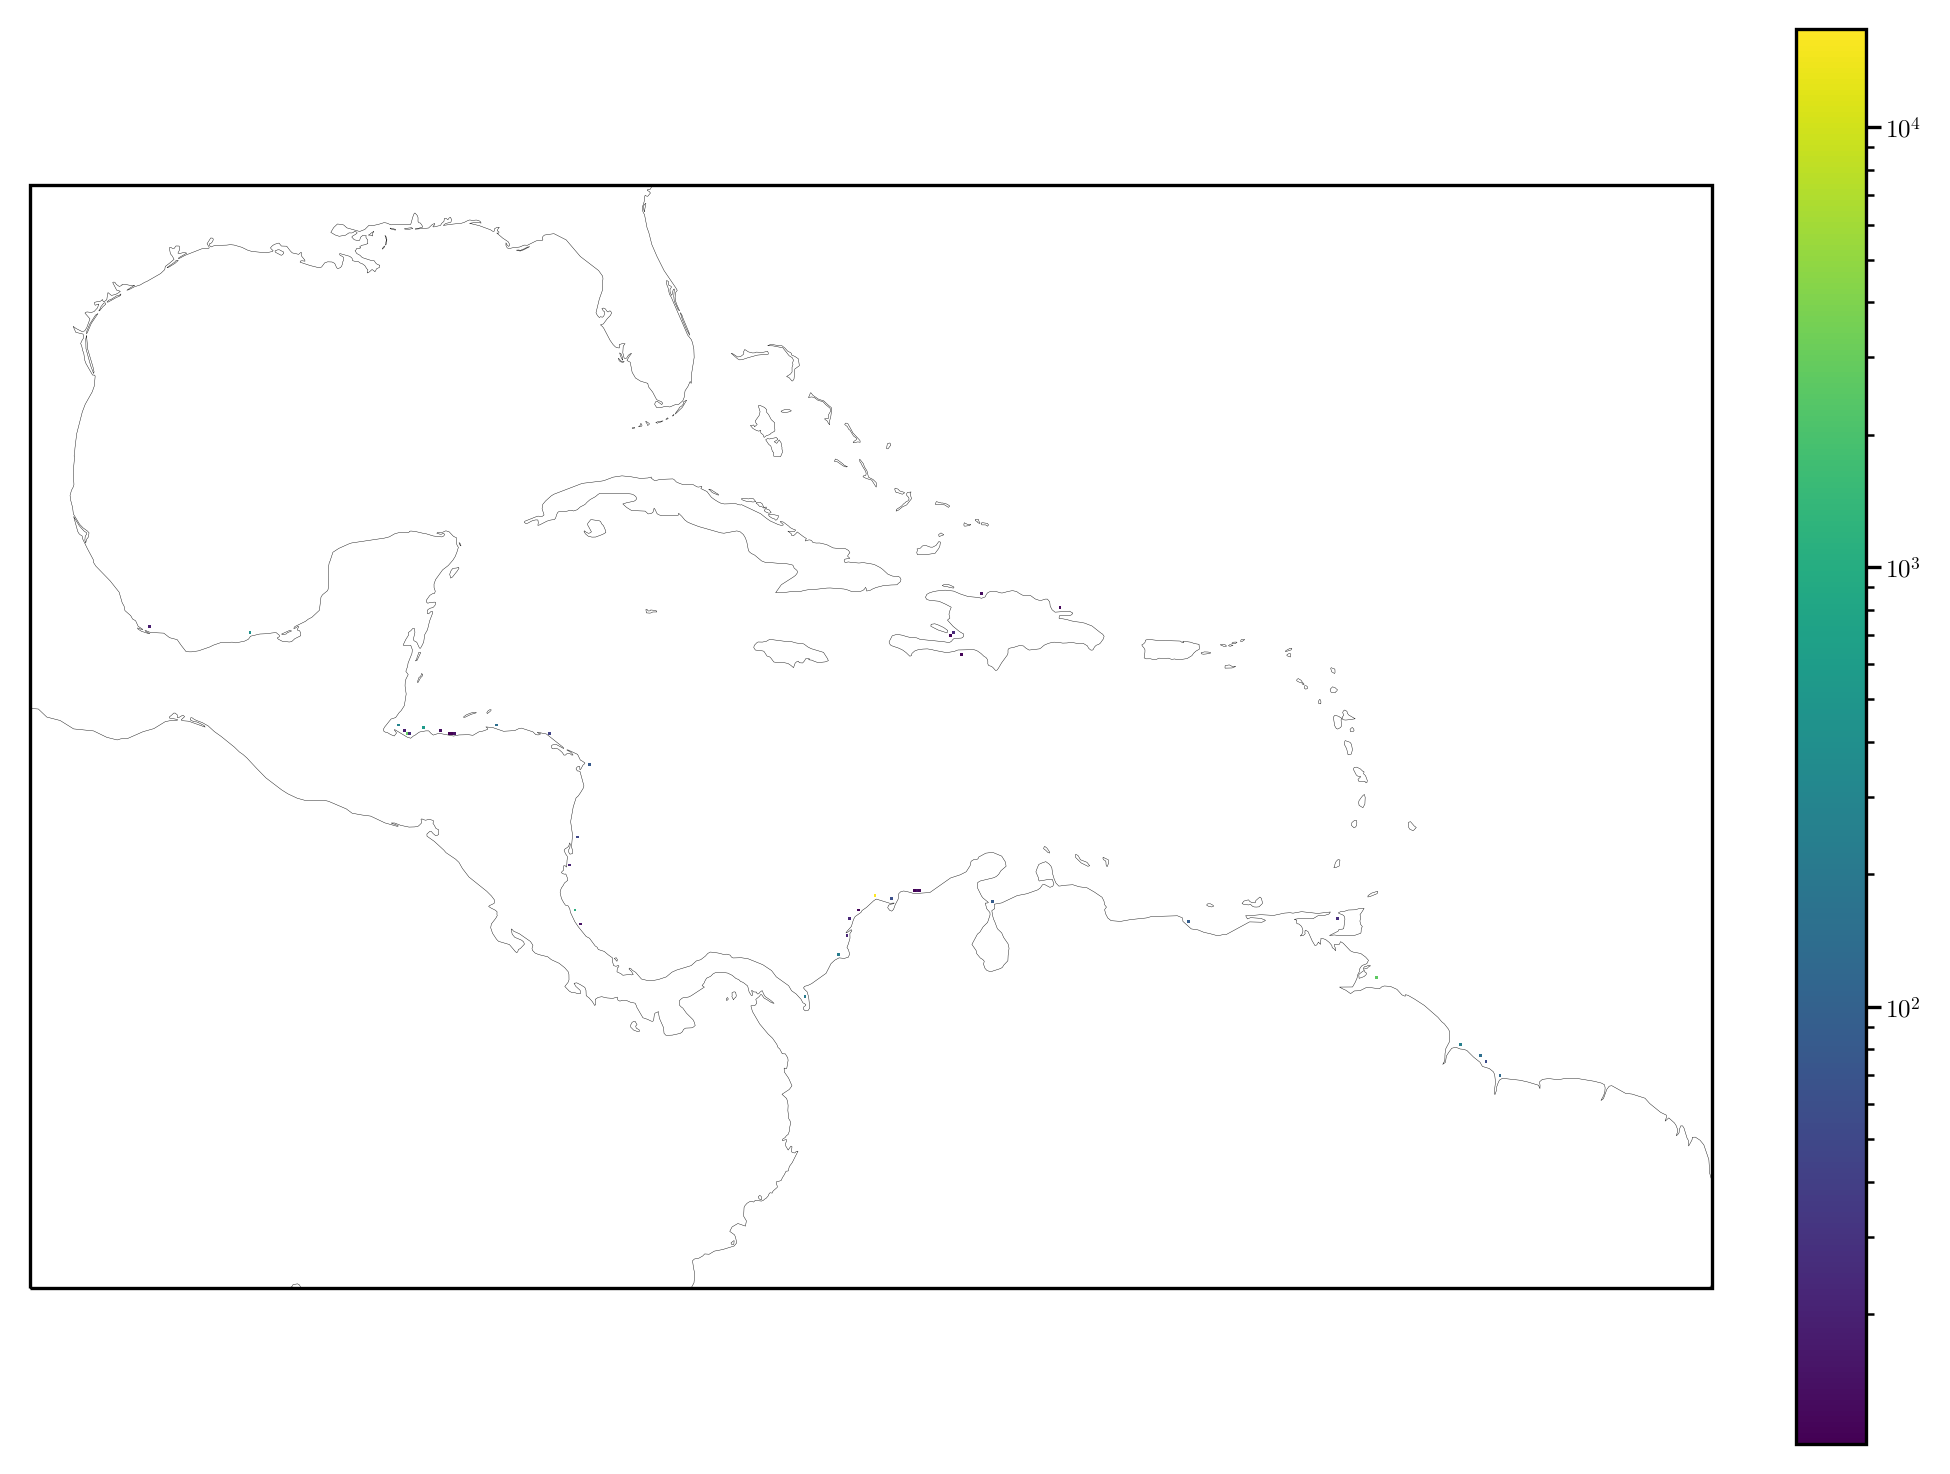

In [45]:
# coastal mpw from rivers
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, aspect="equal", projection=ccrs.PlateCarree())


model_ocean_mpw_r2 = np.copy(model_ocean_mpw_r)
model_ocean_mpw_r2[model_ocean_mpw_r < 10] = 0

pcm1 = ax.pcolormesh(
    qlon, qlat, model_ocean_mpw_r2, shading="auto", norm=colors.LogNorm()
)

ax.add_feature(cfeature.COASTLINE, linewidth=0.1, zorder=1)

ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

fig.colorbar(pcm1, ax=ax)

# Generate particles randomly into model box containing trash

In [46]:
np.random.seed(42)

coast_x_r = []
coast_y_r = []
coast_w_r = []
coast_cid_r = []
pj, pi = np.where(model_ocean_mpw_r > 0)  # index of non zero grid cell
for i in range(0, len(pi)):
    mass = model_ocean_mpw_r[pj[i], pi[i]]
    n = number_of_particles(mass)

    dx = qlon[pi[i] + 1] - qlon[pi[i]]
    dy = qlat[pj[i] + 1] - qlat[pj[i]]

    coast_x_r.append(qlon[pi[i]] + np.random.random_sample(n) * dx)
    coast_y_r.append(qlat[pj[i]] + np.random.random_sample(n) * dy)
    particles_mass = (
        mass / 12 * light_particle_ratio
    )  # weight of monthly light particles [tons]
    coast_w_r.append(np.full(n, particles_mass / n) if n else np.empty(0))
    coast_cid_r.append(
        np.full(n, f_cid([qlon[pi[i]], qlat[pj[i]]]), dtype="int")
        if n
        else np.empty(0, dtype="int")
    )

In [47]:
len(np.unique(np.hstack(coast_cid_r)))

18

In [48]:
print(f"A total of {sum([len(a) for a in coast_x_r])} river particles.")

A total of 789 river particles.


## Coastal vs Rivers input

In [49]:
print(
    f"Rivers account for {np.sum(model_ocean_mpw_r)/(np.sum(model_ocean_mpw_r)+np.sum(model_ocean_mpw))*100:0.1f}% of the plastic in the Caribbean region."
)

Rivers account for 7.9% of the plastic in the Caribbean region.


# Entering particles from the Global model
- resample using hte same amount of particles as coastal and rivers inputs.

In [48]:
def decay(mass: float, age: float):
    """
    Calculate the mass decay of a plastic particles
    Args:
        mass: initial mass of the release plastic
        age: age of the particles [year]

    Returns:
        [float]: mass left in the ocean
    """
    # e-folding time from Chassignet, Xu, Zavala-Romero (2021)
    # 36.8% of plastic left after 5 years
    t0 = 5  # [years]
    return mass * np.exp(-age / t0)

In [58]:
df = pd.read_csv(
    "../data/process/subset_release_locations/inputs.csv", parse_dates=["date"]
)

In [50]:
df.head()

,longitude,latitude,weight [ton],country,country id,date,age [day]
0,-51.603531,4.605586,71.4993,Brazil,33,2010-01-02,1
1,-80.986122,30.869055,12.3412,United States,235,2010-01-03,2
2,-80.498016,30.977859,17.1762,United States,235,2010-01-06,5
3,-80.211388,30.862837,14.2440,United States,235,2010-01-10,9
4,-80.221115,30.936819,13.4405,United States,235,2010-01-11,10


In [51]:
coast_x_i = []
coast_y_i = []
coast_w_i = []
date_i = []
coast_cid_i = []

for i in range(0, len(df)):
    decayed_mass = decay(df.loc[i]["weight [ton]"], df.loc[i]["age [day]"] / 365)
    n = number_of_particles(decayed_mass)

    ix = qlon.searchsorted(df.loc[i]["longitude"], "left") - 1
    iy = qlat.searchsorted(df.loc[i]["latitude"], "left") - 1
    dx = qlon[ix + 1] - qlon[ix]
    dy = qlat[iy + 1] - qlat[iy]

    date_i.append(np.full(n, df.loc[i]["date"]))
    coast_x_i.append(qlon[ix] + np.random.random_sample(n) * dx)
    coast_y_i.append(qlat[iy] + np.random.random_sample(n) * dy)
    particles_mass = decayed_mass / 12 * light_particle_ratio  # [tons]
    coast_w_i.append(np.full(n, particles_mass / n) if n else np.empty(0))
    # NOTE: from the Global list and not only the 40 Caribbean countries
    coast_cid_i.append(
        np.full(n, df.loc[i]["country id"], dtype="int")
        if n
        else np.empty(0, dtype="int")
    )

In [52]:
print(
    f"A total of {sum([len(a) for a in coast_x_i])} entering particles for the 12 years period."
)

A total of 2769360 entering particles for the 12 years period.


In [51]:
2769360 + 12 * (10526 + 789)

2905140

# Output particle files
For the coastal and river particles, it must contains:
- latitude
- longitude
- weight
- id of the release country

For the particles entering the domain, it must also include the date.

In [46]:
output_folder = "../data/process/"
# coast
df_c = pd.DataFrame(
    {
        "longitude": np.hstack(coast_x),
        "latitude": np.hstack(coast_y),
        "weight [ton]": np.hstack(coast_w),
        "country id": np.hstack(coast_cid),
    }
)

# river
df_r = pd.DataFrame(
    {
        "longitude": np.hstack(coast_x_r),
        "latitude": np.hstack(coast_y_r),
        "weight [ton]": np.hstack(coast_w_r),
        "country id": np.hstack(coast_cid_r),
    }
)

# input
df_i = pd.DataFrame(
    {
        "longitude": np.hstack(coast_x_i),
        "latitude": np.hstack(coast_y_i),
        "weight [ton]": np.hstack(coast_w_i),
        "country id": np.hstack(coast_cid_i),
        "date": np.hstack(date_i),
    }
)

df_c.to_csv(join(output_folder, "coasts.csv"), index=False)
df_r.to_csv(join(output_folder, "rivers.csv"), index=False)
df_i.to_csv(join(output_folder, "inputs.csv"), index=False)

# Testing

In [54]:
len(df_c) + len(df_r)

11315

In [55]:
len(np.unique(df_c["country id"]))

25

In [56]:
len(np.unique(df_r["country id"]))

18

In [57]:
len(
    np.unique(np.hstack((np.unique(df_c["country id"]), np.unique(df_r["country id"]))))
)

26

In [58]:
len(np.unique(df_i["country id"]))

78

In [52]:
caribbean_countries = [
    # caribbean countries
    "Antigua and Barbuda",
    "Bahamas",
    "Barbados",
    "Cuba",
    "Dominica",
    "Dominican Republic",
    "Grenada",
    "Haiti",
    "Jamaica",
    "Saint Kitts and Nevis",
    "Saint Lucia",
    "Saint Vincent and the Grenadines",
    "Trinidad and Tobago",
    # dependant teritory
    "Anguilla",
    "Aruba",
    "Bonaire, Sint Eustatius and Saba",
    "British Virgin Islands",
    "Cayman Islands",
    "Curaçao",
    "Guadeloupe",
    "Martinique",
    "Montserrat",
    "Puerto Rico",
    "Saint-Barthélemy",
    "Saint-Martin",
    "Sint Maarten",
    "Turks and Caicos Islands",
    "Virgin Islands, U.S.",
    # nearby countries
    "Mexico",
    "United States",
    "Venezuela",
    "Belize",
    "Colombia",
    "Costa Rica",
    "Guatemala",
    "Guyana",
    "Honduras",
    "Nicaragua",
    "Panama",
    "Suriname",
    # needed to split the coastlines of USA properly (not part of the output!)
    "Canada",
]

In [ ]:
# some validations
for c_id in range(0, len(caribbean_countries)):
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND, facecolor="grey", zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)

    ax.scatter(
        df_c.loc[df_c["country id"] == c_id, "longitude"],
        df_c.loc[df_c["country id"] == c_id, "latitude"],
        s=3,
        c="r",
    )
    ax.scatter(
        df_r.loc[df_r["country id"] == c_id, "longitude"],
        df_r.loc[df_r["country id"] == c_id, "latitude"],
        s=3,
        c="b",
    )

    if np.all((df_c["country id"] == c_id) == False) and np.all(
        (df_r["country id"] == c_id) == False
    ):
        print(f"No data from {caribbean_countries[c_id]}")

    ax.set_title(caribbean_countries[c_id])
    ax.set_xlim([-98, -53])
    ax.set_ylim([4.5, 32])
    ax.set_xticks([-95, -85, -75, -65, -55], crs=ccrs.PlateCarree())
    ax.set_yticks([10, 20, 30], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())